##1. Imports and Drive mounting


In [55]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os
from sklearn.metrics import mean_absolute_error

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from google.colab import files
import pathlib
from tensorflow.keras import regularizers
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


!ls '/content/gdrive/My Drive/'

2.4.1
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'Backups '	    'France roadtrip 2020.gmap'   presentations
'Beleggen '	     Git			 'Running tracks'
 Blockchain	     Letter.gdoc		  Scraping
 Brouwerij	     Limoncello			  Spark
'Colab Notebooks'   'Machine Learning '		 'The Unix Workbench'
 Dask		    'New Laptop'		  Travel
'Data engineering'   OOP			 'Web development'
 Education	     PhD
 Fietsen	     PowerBI


##2. Reading the data set


In [2]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/PhD/UGent courses/Deep Learning/Assignments/GA3/preprocessed_data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

#train_dataset.plot(subplots=True,figsize=(16,26))

##3. Extract train, validate and test features and labels

In the code below, we will split of a validation set that is the same size as the test set (1 year) at the end of the training set.

In [3]:
print(train_dataset.columns)
print(len(train_dataset.columns))

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'seasons_cos', 'seasons_sin', 'hour_cos', 'hour_sin', 'weekdays',
       'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Tuesday', 'is_Wednesday', 'NE_strength', 'NW_strength',
       'NS_strength', 'cv_strength'],
      dtype='object')
23


In [4]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

#using indexing, you can select which features you want to use (adapt to your needs)
features = range(0,len(train_dataset.columns))

# index of the pollution data in the complete preprocessed feature set 
pollution = 0


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

# data for retraining before testing
train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

# test data
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


# check
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 23)
(26280,)
(8760, 23)
(8760,)
(35040, 23)
(35040,)
(8760, 23)
(8760,)


##4. Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models. Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.


In [5]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = StandardScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

##5. Transforming the data into the right format for model training

In the code below, helper functions are defined for the window-based model.

In [6]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

In [7]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()


In [8]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

##6. Building the unregularized CNN model


In [45]:
#Choose the Window size that will be used to create the lagged features

def construct_model(CNN_WINDOW_SIZE):

  CNNmodel = Sequential()
  CNNmodel.add(Conv1D(input_shape = (CNN_WINDOW_SIZE, X_train_w.shape[-1]), 
                          filters=16,
                          kernel_size=1,
                          padding='same'))
  #CNNmodel.add(BatchNormalization())
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(Conv1D(filters=16,
                          kernel_size=3,
                          padding='same'))
  #CNNmodel.add(BatchNormalization())
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(MaxPooling1D(pool_size=2))

  CNNmodel.add(Conv1D(filters=32,
                          kernel_size=3,
                          padding='same'))
  #CNNmodel.add(BatchNormalization())
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(Conv1D(filters=32,
                          kernel_size=3,
                          padding='same'))
  #CNNmodel.add(BatchNormalization())
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(MaxPooling1D(pool_size=2))

  CNNmodel.add(Flatten())
  CNNmodel.add(Dense(64, activation='relu'))
  CNNmodel.add(Dense(1))
  CNNmodel.add(Activation('linear'))

  CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

  return CNNmodel

In [46]:
print(train_dataset.columns)

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'seasons_cos', 'seasons_sin', 'hour_cos', 'hour_sin', 'weekdays',
       'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Tuesday', 'is_Wednesday', 'NE_strength', 'NW_strength',
       'NS_strength', 'cv_strength'],
      dtype='object')


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 6, 16)             384       
_________________________________________________________________
activation_120 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 6, 16)             784       
_________________________________________________________________
activation_121 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 3, 16)             0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 3, 32)             1568      
_________________________________________________________________
activation_122 (Activation)  (None, 3, 32)           

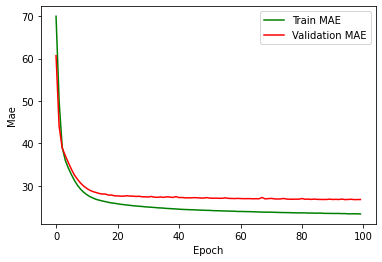

In [48]:
#Selecting the train features to use in the model
#train_features = [0,] #Using pollution feature only
train_features = range(0,len(train_dataset.columns)) #Using all features
CNN_WINDOW_SIZE = 6

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=CNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=CNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)

CNNmodel = construct_model(CNN_WINDOW_SIZE)
CNNmodel.summary()

batch_size=32
epochs=100
CNN_history = CNNmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)

y_train_CNNmodel = CNNmodel.predict(X_train_w)
y_val_CNNmodel = CNNmodel.predict(X_val_w)

mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

print("Train MAE= ",mae_train_CNNmodel)
print("Validation MAE= ",mae_val_CNNmodel)
plot_history(CNN_history)

##7. Building the regularized CNN model

In [90]:
#Choose the Window size that will be used to create the lagged features

def construct_model(CNN_WINDOW_SIZE):
  l1 = 1e-3
  l2 = 1e-1
  l1_dense = 0
  l2_dense = 0
  maxnorm_dense = 2

  CNNmodel = Sequential()
  CNNmodel.add(Conv1D(input_shape = (CNN_WINDOW_SIZE, 23), 
                          filters=16,
                          kernel_size=1,
                          padding='same',
                          kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(Conv1D(filters=16,
                          kernel_size=3,
                          padding='same',
                          kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(MaxPooling1D(pool_size=2))

  CNNmodel.add(Conv1D(filters=32,
                          kernel_size=3,
                          padding='same',
                          kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(Conv1D(filters=32,
                          kernel_size=3,
                          padding='same',
                          kernel_regularizer=regularizers.L1L2(l1= l1, l2= l2)))
  CNNmodel.add(Activation('relu'))
  CNNmodel.add(MaxPooling1D(pool_size=2))

  CNNmodel.add(Flatten())
  CNNmodel.add(Dense(64, activation='relu',kernel_regularizer=regularizers.L1L2(l1= l1_dense, l2= l2_dense),
                     kernel_constraint=max_norm(maxnorm_dense)))
  CNNmodel.add(Dropout(0.1))
  CNNmodel.add(Dense(1))
  CNNmodel.add(Activation('linear'))

  CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

  return CNNmodel

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_238 (Conv1D)          (None, 6, 16)             384       
_________________________________________________________________
activation_295 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
conv1d_239 (Conv1D)          (None, 6, 16)             784       
_________________________________________________________________
activation_296 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_117 (MaxPoolin (None, 3, 16)             0         
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 3, 32)             1568      
_________________________________________________________________
activation_297 (Activation)  (None, 3, 32)           

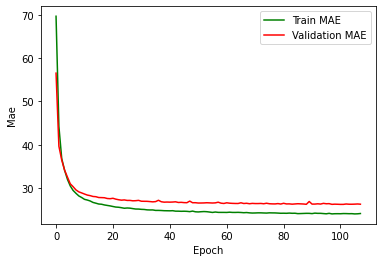

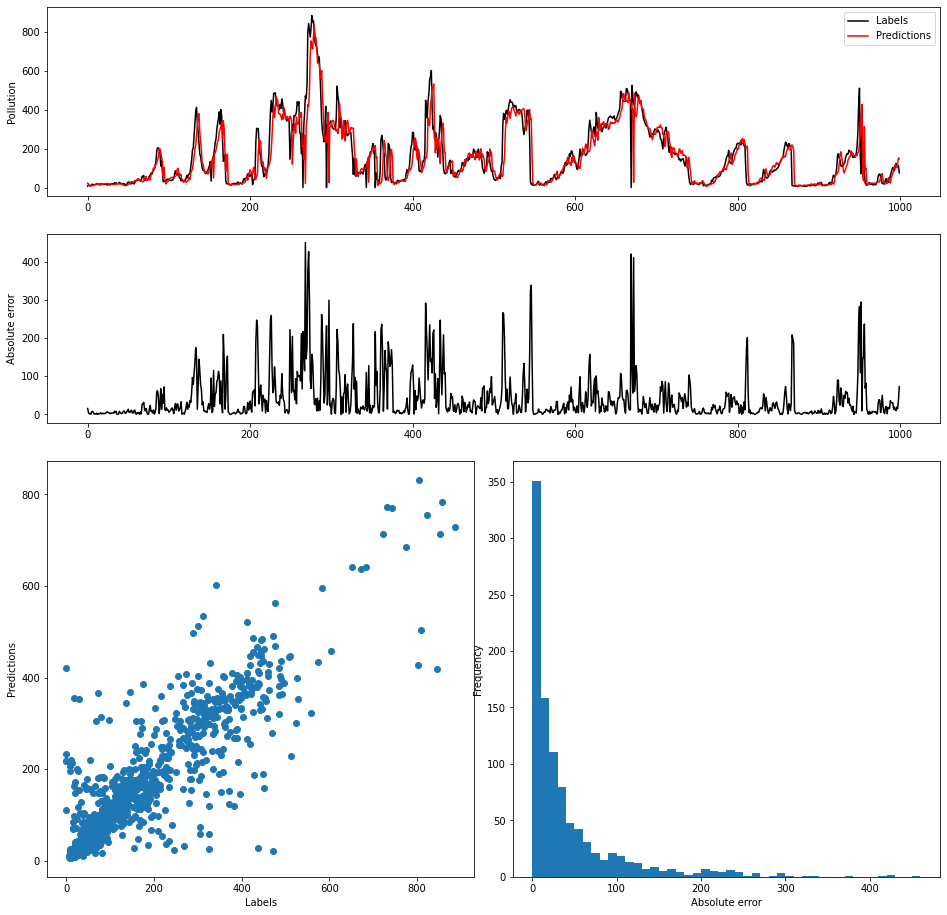

In [87]:
#Selecting the train features to use in the model
#train_features = [0,] #Using pollution feature only
train_features = range(0,len(train_dataset.columns)) #Using all features
CNN_WINDOW_SIZE = 6

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=CNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=CNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)

CNNmodel = construct_model(CNN_WINDOW_SIZE)
CNNmodel.summary()

checkpoint_dir = '/content/gdrive/My Drive/PhD/UGent courses/Deep Learning/Assignments/GA3/preprocessed_data/'
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"initialmodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"

#code for modelcheckpoint and early stopping  commented below
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor='val_mae',
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,min_delta=0.01)

batch_size=32
epochs=200
CNN_history = CNNmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          callbacks = [cp_callback, stopping_callback],
          shuffle=True)

## Reconstruct best model and evaluate performance on train and val set
# Find latest checkpoint
# Sort the checkpoints by modification time.
checkpoints = pathlib.Path(checkpoint_dir).glob("*.index")
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)
checkpoints = [cp.with_suffix('') for cp in checkpoints]
latest = str(checkpoints[-1])

# Now restore the model
best_CNN_model = construct_model(CNN_WINDOW_SIZE) # this is a new model
best_CNN_model.load_weights(latest)

y_train_CNNmodel = best_CNN_model.predict(X_train_w)
y_val_CNNmodel = best_CNN_model.predict(X_val_w)

mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

print("Best CNN Windowed model with early stopping:")
print("Train MAE = ",mae_train_CNNmodel)
print("Validation MAE = ",mae_val_CNNmodel)

plot_history(CNN_history)

PlotResults(r_val_w[:1000],y_val_CNNmodel[:1000,0])

##8. Train best model on full training set and evaluate performance on the test set

In [91]:
# Code needs to be adapted to the best model so far!!!!
CNN_WINDOW_SIZE = 6
train_features = range(0,len(train_dataset.columns)) #Using all features

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)

#Recreate the best optimal model

CNNmodel = construct_model(CNN_WINDOW_SIZE)
CNNmodel.summary()

batch_size=32
epochs= 101

CNN_history = CNNmodel.fit(X_train_all_w, r_train_all_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True)

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_254 (Conv1D)          (None, 6, 16)             384       
_________________________________________________________________
activation_315 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
conv1d_255 (Conv1D)          (None, 6, 16)             784       
_________________________________________________________________
activation_316 (Activation)  (None, 6, 16)             0         
_________________________________________________________________
max_pooling1d_125 (MaxPoolin (None, 3, 16)             0         
_________________________________________________________________
conv1d_256 (Conv1D)          (None, 3, 32)             1568      
_________________________________________________________________
activation_317 (Activation)  (None, 3, 32)           

"Regularized and Windowed CNN " model:
 train all mae =  24.276102 
 test mae =  23.671429


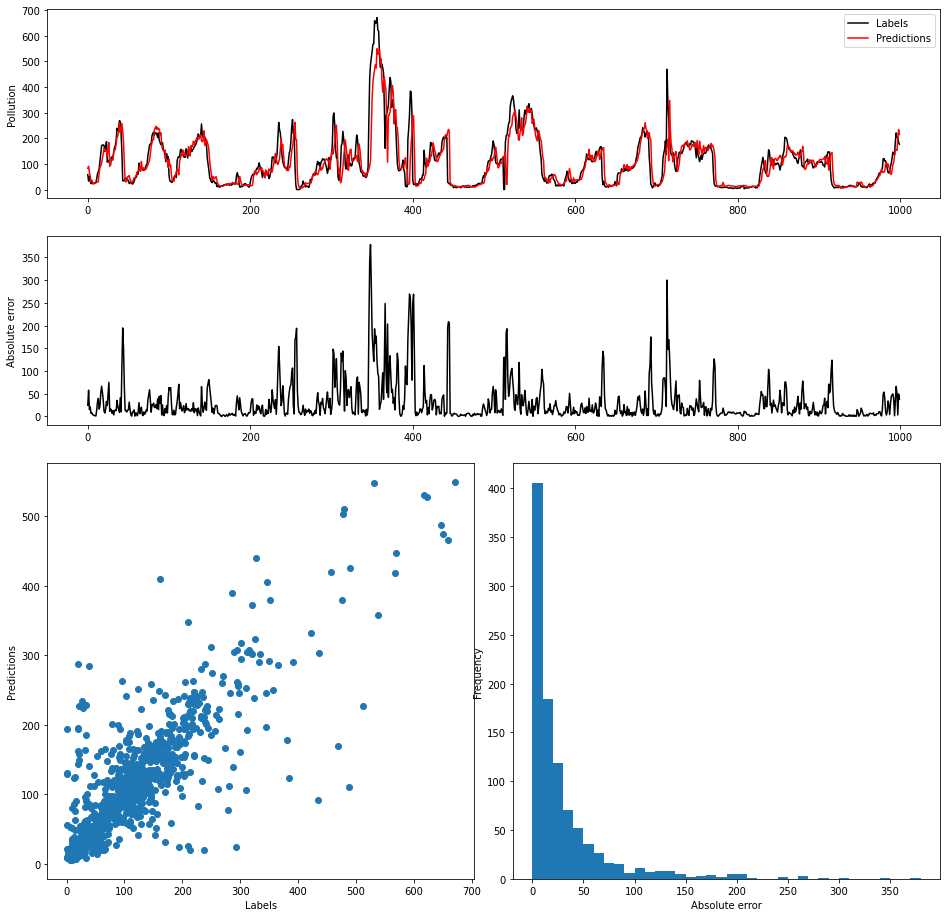

In [92]:
y_train_all_CNNmodel = CNNmodel.predict(X_train_all_w)
y_test_CNNmodel = CNNmodel.predict(X_test_w)

mae_train_all_CNNmodel = mean_absolute_error(r_train_all_w,y_train_all_CNNmodel)
mae_test_CNNmodel = mean_absolute_error(r_test_w,y_test_CNNmodel)

print("\"Regularized and Windowed CNN \" model:\n train all mae = ",mae_train_all_CNNmodel, "\n test mae = ",mae_test_CNNmodel)
PlotResults(r_test_w[:1000],y_test_CNNmodel[:1000,0])